In [1]:
# 참고
#https://deep-deep-deep.tistory.com/60

In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-07-06 01:21:03.433451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 01:21:03.455896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 01:21:03.456325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
if not os.path.exists('./TIME_SERIES/'):
    os.mkdir('./TIME_SERIES/')
if not os.path.exists('./TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/'):
    os.mkdir('./TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/')
if not os.path.exists('./TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/'):
    os.mkdir('./TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/')
    
print(os.getcwd())

/home/alfa_members/hyunjo/tensorflow2


In [4]:
# <---------------- Google Colab에서 돌릴 경우 ----------------> 

# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
dict_args = dict()
dict_args['raw_file'] = './TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/WEATHER_ASOS_2205.csv'  # 필요시 경로 변경
dict_args['preprocessed_file'] = './TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/CLEAN_WEATHER_ASOS_2205.csv'  # 필요시 경로 변경
dict_args["window_size"] = 4
dict_args["features"] = ['기온(°C)','풍속(m/s)','습도(%)']
dict_args["label"] = ['기온(°C)']
dict_args["index"] = ['지점','지점명','일시']
dict_args["area"] = "속초"
dict_args["test_size"] = 120
dict_args['model_file'] = './TIME_SERIES/MODEL1/'
dict_args["param_list"] =  {
                            "LSTM": {'epochs': 60,
                                      'batch_size': 50,
                                      'learning_rate': 0.0005,
                                    },
                            "GRU": 
                                    {'epochs': 60,
                                      'batch_size': 50,
                                      'learning_rate': 0.0005,
                                    },
                            }


In [6]:
def make_preprocessed_file(p_args):
    
    try: 
        df = pd.read_csv(p_args['raw_file'], encoding='utf-8') 
    except:
        df = pd.read_csv(p_args['raw_file'], encoding='euc-kr')     
    # display(df)
    # print(df.columns)
    columns = p_args['index']
    columns.extend(p_args["features"])
    print(columns)

    df = df[columns]
    df = df[df['지점명'] == p_args["area"]] 
    df.index = pd.to_datetime(df['일시'], format='%Y-%m-%d %H:%S')

    df = df[p_args["features"]]
    df = df.astype('float32')
    print(df.info())
    print(df.isna().sum())
    display(df)
    df.to_csv(p_args['preprocessed_file'], encoding='utf-8')


def make_dataset_regression(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        # print('feature list: ', np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
        # print('label list: ', np.array(data.iloc[i:i+window_size])) 
    return np.array(feature_list), np.array(label_list)


def split_dataset_regression(p_args, scaling_flag=True):
    # 파일 읽기
    df = pd.read_csv(p_args["preprocessed_file"])
    df = df.fillna(0)
    df = df.set_index('일시')
    df = df.astype(float)

    # 수치 정규화 
    if scaling_flag: 
        print('정규화된 데이터입니다.')
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        df_scaled = scaler.fit_transform(df)

        df_scaled = pd.DataFrame(df_scaled)
        df_scaled.columns = df.columns
        df_scaled = df_scaled.set_index(df.index)
        # display(df_scaled.head(5))
    else:
        print('정규화가 제외된 데이터입니다.')
        df_scaled = df.copy()
        # display(df_scaled.head(5))
    
    # Train과 Test 분리
    train = df_scaled[:-p_args["test_size"]]
    test = df_scaled[-p_args["test_size"]:]
    print("train: ", train.shape, type(train))
    print("test: ", test.shape, type(test))
    # display(train.head(5))
    # display(test.head(5))
    
    train_feature, train_label = make_dataset_regression(train[dict_args["features"]], train[dict_args["label"]], window_size = p_args["window_size"])
    print("train_feature: ", train_feature.shape, type(train_feature))
    print("train_label: ", train_label.shape, type(train_label))
    
    # Train에서 Train Set, Valid Set 분리 (검증셋)
    from sklearn.model_selection import train_test_split
    X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size = 0.2)
    
    y_train = y_train.reshape(len(y_train))
    y_valid = y_valid.reshape(len(y_valid))
    X_train = X_train.astype(float)
    y_train = y_train.astype(float)
    X_valid = X_valid.astype(float)
    y_valid = y_valid.astype(float)

    print("X_train: ",  X_train.shape, type(X_train))
    print("y_train: ",  y_train.shape, type(y_train))
    print("X_valid: ",  X_valid.shape, type(X_valid))
    print("y_valid: ",  y_valid.shape, type(y_valid))
    
    # Test set에서 feature, label 분리
    X_test, y_test = make_dataset_regression(test[dict_args["features"]], test[dict_args["label"]], window_size = p_args["window_size"])
    y_test = y_test.reshape(len(y_test))
    print("X_test: ", X_test.shape)
    print("y_test: ", y_test.shape)
    
    print(X_train[0])
    print(y_train[0])

    return train, test, train_feature, train_label, X_train, y_train, X_valid, y_valid, X_test, y_test


def build_LSTM_model(p_args, train_set):
    model = Sequential()
    model.add(LSTM(32, 
              input_shape=(train_set.shape[1], train_set.shape[2]),
              activation='relu',
              return_sequences=False))
    model.add(Dense(4, 'relu'))
    model.add(Dense(1))
    print(model.summary())

    # cp = ModelCheckpoint(p_args['model_file'], save_best_only=True)
    model.compile(loss='mean_squared_error', 
                  optimizer= Adam(learning_rate=dict_args["param_list"]["LSTM"]["learning_rate"]), 
                  metrics=['mae'],
                  )
    return model

In [7]:
make_preprocessed_file(dict_args)

['지점', '지점명', '일시', '기온(°C)', '풍속(m/s)', '습도(%)']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2022-05-01 01:00:00 to 2022-06-01 00:00:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   기온(°C)   744 non-null    float32
 1   풍속(m/s)  744 non-null    float32
 2   습도(%)    744 non-null    float32
dtypes: float32(3)
memory usage: 14.5 KB
None
기온(°C)     0
풍속(m/s)    0
습도(%)      0
dtype: int64


/tmp/ipykernel_1117655/824568468.py:1: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  make_preprocessed_file(dict_args)


,기온(°C),풍속(m/s),습도(%)
일시,,,
2022-05-01 01:00:00,11.400000,1.7,46.0
2022-05-01 02:00:00,11.900000,3.4,38.0
2022-05-01 03:00:00,10.700000,2.7,46.0
2022-05-01 04:00:00,10.500000,1.9,44.0
2022-05-01 05:00:00,10.200000,1.2,40.0
...,...,...,...
2022-05-31 20:00:00,24.299999,2.6,23.0
2022-05-31 21:00:00,22.799999,1.6,28.0
2022-05-31 22:00:00,22.700001,1.9,23.0


In [8]:
train, test, train_feature, train_label, X_train, y_train, X_valid, y_valid, X_test, y_test = split_dataset_regression(dict_args, scaling_flag=True)

정규화된 데이터입니다.
train:  (624, 3) <class 'pandas.core.frame.DataFrame'>
test:  (120, 3) <class 'pandas.core.frame.DataFrame'>
train_feature:  (620, 4, 3) <class 'numpy.ndarray'>
train_label:  (620, 1) <class 'numpy.ndarray'>
X_train:  (496, 4, 3) <class 'numpy.ndarray'>
y_train:  (496,) <class 'numpy.ndarray'>
X_valid:  (124, 4, 3) <class 'numpy.ndarray'>
y_valid:  (124,) <class 'numpy.ndarray'>
X_test:  (116, 4, 3)
y_test:  (116,)
[[0.76404494 0.41975309 0.22891566]
 [0.5917603  0.41975309 0.37349398]
 [0.53932584 0.18518519 0.44578313]
 [0.53558052 0.22222222 0.40963855]]
0.6554307116104869


In [9]:
model1 = build_LSTM_model(dict_args, X_train)
# cp1 = LSTM_model(dict_args, X_train)
# print(cp1)

epochs = dict_args["param_list"]["LSTM"]["epochs"]
batch_size = dict_args["param_list"]["LSTM"]["batch_size"]

model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
           epochs=epochs, 
           batch_size=batch_size,
           callbacks=[ModelCheckpoint(dict_args['model_file'], save_best_only=True)],
) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 4,745
Trainable params: 4,745
Non-trainable params: 0
_________________________________________________________________


2022-07-06 01:21:03.831609: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 01:21:03.832368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 01:21:03.832833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 01:21:03.833292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

None
Epoch 1/60


2022-07-06 01:21:05.595017: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 1/10 [==>...........................] - ETA: 13s - loss: 0.1998 - mae: 0.4106

2022-07-06 01:21:06.316718: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 3s 116ms/step - loss: 0.1596 - mae: 0.3540 - val_loss: 0.1488 - val_mae: 0.3426
Epoch 2/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.1583 - mae: 0.3620INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 105ms/step - loss: 0.1187 - mae: 0.2981 - val_loss: 0.1053 - val_mae: 0.2809
Epoch 3/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.1040 - mae: 0.2756INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 100ms/step - loss: 0.0795 - mae: 0.2356 - val_loss: 0.0685 - val_mae: 0.2236
Epoch 4/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0731 - mae: 0.2243INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 99ms/step - loss: 0.0504 - mae: 0.1841 - val_loss: 0.0425 - val_mae: 0.1755
Epoch 5/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0388 - mae: 0.1580INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 111ms/step - loss: 0.0319 - mae: 0.1505 - val_loss: 0.0277 - val_mae: 0.1442
Epoch 6/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0268 - mae: 0.1435INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0224 - mae: 0.1272 - val_loss: 0.0202 - val_mae: 0.1221
Epoch 7/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0157 - mae: 0.1010INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 106ms/step - loss: 0.0174 - mae: 0.1109 - val_loss: 0.0153 - val_mae: 0.1048
Epoch 8/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0128 - mae: 0.0951INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0130 - mae: 0.0947 - val_loss: 0.0114 - val_mae: 0.0901
Epoch 9/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0082 - mae: 0.0740INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0096 - mae: 0.0799 - val_loss: 0.0090 - val_mae: 0.0787
Epoch 10/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0079 - mae: 0.0739INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 108ms/step - loss: 0.0078 - mae: 0.0706 - val_loss: 0.0074 - val_mae: 0.0702
Epoch 11/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0082 - mae: 0.0751INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0066 - mae: 0.0643 - val_loss: 0.0067 - val_mae: 0.0650
Epoch 12/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0044 - mae: 0.0522INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 107ms/step - loss: 0.0060 - mae: 0.0612 - val_loss: 0.0064 - val_mae: 0.0639
Epoch 13/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0062 - mae: 0.0602INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0058 - mae: 0.0600 - val_loss: 0.0064 - val_mae: 0.0635
Epoch 14/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0051 - mae: 0.0569INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0057 - mae: 0.0596 - val_loss: 0.0063 - val_mae: 0.0630
Epoch 15/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0049 - mae: 0.0578INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 108ms/step - loss: 0.0057 - mae: 0.0596 - val_loss: 0.0062 - val_mae: 0.0627
Epoch 16/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0056 - mae: 0.0592 - val_loss: 0.0062 - val_mae: 0.0628
Epoch 17/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0063 - mae: 0.0673INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0055 - mae: 0.0588 - val_loss: 0.0061 - val_mae: 0.0619
Epoch 18/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0043 - mae: 0.0506INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0054 - mae: 0.0583 - val_loss: 0.0060 - val_mae: 0.0617
Epoch 19/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0061 - mae: 0.0625INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 106ms/step - loss: 0.0053 - mae: 0.0578 - val_loss: 0.0060 - val_mae: 0.0614
Epoch 20/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0047 - mae: 0.0555INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0053 - mae: 0.0573 - val_loss: 0.0059 - val_mae: 0.0608
Epoch 21/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0062 - mae: 0.0605INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 108ms/step - loss: 0.0052 - mae: 0.0571 - val_loss: 0.0058 - val_mae: 0.0606
Epoch 22/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0051 - mae: 0.0571INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0051 - mae: 0.0566 - val_loss: 0.0058 - val_mae: 0.0604
Epoch 23/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0059 - mae: 0.0583INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0051 - mae: 0.0563 - val_loss: 0.0057 - val_mae: 0.0600
Epoch 24/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0029 - mae: 0.0409INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 112ms/step - loss: 0.0050 - mae: 0.0559 - val_loss: 0.0056 - val_mae: 0.0597
Epoch 25/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0041 - mae: 0.0512INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0049 - mae: 0.0556 - val_loss: 0.0056 - val_mae: 0.0596
Epoch 26/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0057 - mae: 0.0608INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0049 - mae: 0.0553 - val_loss: 0.0055 - val_mae: 0.0593
Epoch 27/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0042 - mae: 0.0500INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 105ms/step - loss: 0.0048 - mae: 0.0549 - val_loss: 0.0055 - val_mae: 0.0592
Epoch 28/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0056 - mae: 0.0592INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0047 - mae: 0.0548 - val_loss: 0.0054 - val_mae: 0.0588
Epoch 29/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0037 - mae: 0.0489INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 109ms/step - loss: 0.0047 - mae: 0.0544 - val_loss: 0.0054 - val_mae: 0.0586
Epoch 30/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0047 - mae: 0.0539INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0046 - mae: 0.0540 - val_loss: 0.0054 - val_mae: 0.0583
Epoch 31/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0042 - mae: 0.0516INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0046 - mae: 0.0542 - val_loss: 0.0053 - val_mae: 0.0582
Epoch 32/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0047 - mae: 0.0553INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 112ms/step - loss: 0.0046 - mae: 0.0535 - val_loss: 0.0053 - val_mae: 0.0579
Epoch 33/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0055 - mae: 0.0607INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0045 - mae: 0.0535 - val_loss: 0.0053 - val_mae: 0.0578
Epoch 34/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0035 - mae: 0.0480INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 105ms/step - loss: 0.0044 - mae: 0.0529 - val_loss: 0.0052 - val_mae: 0.0574
Epoch 35/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0050 - mae: 0.0590INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0044 - mae: 0.0526 - val_loss: 0.0052 - val_mae: 0.0571
Epoch 36/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0036 - mae: 0.0487INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0043 - mae: 0.0524 - val_loss: 0.0051 - val_mae: 0.0569
Epoch 37/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0049 - mae: 0.0528INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 112ms/step - loss: 0.0043 - mae: 0.0521 - val_loss: 0.0051 - val_mae: 0.0567
Epoch 38/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0050 - mae: 0.0563INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0043 - mae: 0.0521 - val_loss: 0.0050 - val_mae: 0.0565
Epoch 39/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0030 - mae: 0.0426INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0042 - mae: 0.0516 - val_loss: 0.0050 - val_mae: 0.0561
Epoch 40/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0040 - mae: 0.0504INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 108ms/step - loss: 0.0042 - mae: 0.0513 - val_loss: 0.0050 - val_mae: 0.0560
Epoch 41/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0045 - mae: 0.0546INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0041 - mae: 0.0510 - val_loss: 0.0049 - val_mae: 0.0556
Epoch 42/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0037 - mae: 0.0478INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 105ms/step - loss: 0.0041 - mae: 0.0507 - val_loss: 0.0049 - val_mae: 0.0554
Epoch 43/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0048 - mae: 0.0554INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0040 - mae: 0.0506 - val_loss: 0.0048 - val_mae: 0.0553
Epoch 44/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0051 - mae: 0.0558INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0040 - mae: 0.0502 - val_loss: 0.0048 - val_mae: 0.0549
Epoch 45/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0041 - mae: 0.0513INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 109ms/step - loss: 0.0040 - mae: 0.0501 - val_loss: 0.0048 - val_mae: 0.0546
Epoch 46/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0045 - mae: 0.0523INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0039 - mae: 0.0495 - val_loss: 0.0047 - val_mae: 0.0543
Epoch 47/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0031 - mae: 0.0440INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0039 - mae: 0.0493 - val_loss: 0.0047 - val_mae: 0.0544
Epoch 48/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0037 - mae: 0.0488INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 107ms/step - loss: 0.0038 - mae: 0.0491 - val_loss: 0.0046 - val_mae: 0.0539
Epoch 49/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0040 - mae: 0.0500INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0038 - mae: 0.0487 - val_loss: 0.0046 - val_mae: 0.0537
Epoch 50/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0033 - mae: 0.0462INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 106ms/step - loss: 0.0037 - mae: 0.0485 - val_loss: 0.0046 - val_mae: 0.0534
Epoch 51/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0034 - mae: 0.0464INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0037 - mae: 0.0481 - val_loss: 0.0045 - val_mae: 0.0531
Epoch 52/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0046 - mae: 0.0542INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0037 - mae: 0.0479 - val_loss: 0.0045 - val_mae: 0.0528
Epoch 53/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0033 - mae: 0.0437INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 109ms/step - loss: 0.0036 - mae: 0.0477 - val_loss: 0.0045 - val_mae: 0.0525
Epoch 54/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0030 - mae: 0.0442INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0036 - mae: 0.0476 - val_loss: 0.0044 - val_mae: 0.0522
Epoch 55/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0029 - mae: 0.0413INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0036 - mae: 0.0469 - val_loss: 0.0044 - val_mae: 0.0517
Epoch 56/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0042 - mae: 0.0474INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 110ms/step - loss: 0.0035 - mae: 0.0469 - val_loss: 0.0044 - val_mae: 0.0516
Epoch 57/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0033 - mae: 0.0428INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0035 - mae: 0.0465 - val_loss: 0.0043 - val_mae: 0.0513
Epoch 58/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0038 - mae: 0.0476INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 109ms/step - loss: 0.0035 - mae: 0.0464 - val_loss: 0.0043 - val_mae: 0.0513
Epoch 59/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0042 - mae: 0.0521INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0035 - mae: 0.0464 - val_loss: 0.0043 - val_mae: 0.0507
Epoch 60/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0024 - mae: 0.0375INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL1/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0034 - mae: 0.0458 - val_loss: 0.0042 - val_mae: 0.0505


In [10]:
from tensorflow.keras.models import load_model
model1 = load_model('./TIME_SERIES/MODEL1')

In [11]:
train_predictions = model1.predict(X_test).flatten()
train_results = pd.DataFrame(data={'Test Predictions':train_predictions, 'Actuals':y_test})
train_results

,Test Predictions,Actuals
0,0.432745,0.415730
1,0.427730,0.411985
2,0.420504,0.404494
3,0.412802,0.498127
4,0.470944,0.528090
...,...,...
111,0.729547,0.677903
112,0.701846,0.621723
113,0.650049,0.617978
114,0.625836,0.636704


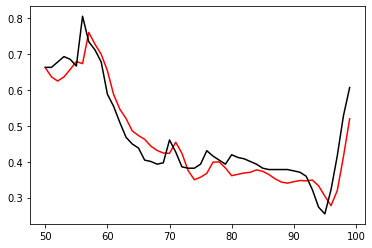

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_results['Test Predictions'][50:100], 'r')
plt.plot(train_results['Actuals'][50:100], 'k')